In [1]:
import sys
import os

src_dir = os.path.dirname(os.getcwd())

if src_dir not in sys.path:
    sys.path.append(src_dir)
    
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
from utils import (
    ddpm_schedules, 
    CNN, 
    DDPM, 
    load_pickle, 
    CNNClassifier, 
    save_pickle, 
    calc_loss_per_epoch, 
    load_model,
    get_feature_vector,
    calculate_fid,
    generate_samples,
    gaussian_blur_schedule,
    save_images
)
from plotting_utils import format_axes
import numpy as np
import torch
from scipy.stats import multivariate_normal
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import GaussianBlur

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# q2_noise_schedule.png

In [58]:
def calc_cell_residual_proportion(sigma, kernel_size):
    """
    A function, when given the standard deviation of a 2D Gaussian kernel and the kernel size, 
    returns the proportion of the central cell that is still the central cell.
    """
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd number.")
    
    # Half the kernel size
    k = kernel_size // 2

    # Create a grid of (x,y) coordinates at which to evaluate the kernel
    x, y = np.mgrid[-k:k+1, -k:k+1]
    pos = np.dstack((x, y))

    # Multivariate normal distribution with diagonal covariance matrix for 2D Gaussian
    rv = multivariate_normal([0, 0], [[sigma**2, 0], [0, sigma**2]])

    # Evaluate the kernel on the grid
    kernel = rv.pdf(pos)

    # The weight of the central cell
    central_value = kernel[k, k]

    # Sum of all weights in the kernel
    sum_of_kernel_values = np.sum(kernel)

    # Proportion of the current cell's value
    proportion = central_value / sum_of_kernel_values

    return proportion

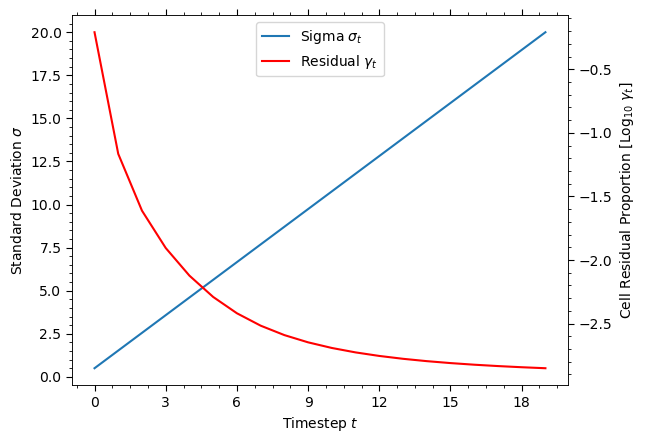

In [66]:
# Generate the noise schedule that was used in the training
noise_schedule = gaussian_blur_schedule(0.5, 20, 20)

# Plot and format the graph
fig, ax = plt.subplots()
plt.plot(noise_schedule, label=r'Sigma $\sigma_{t}$')

plt.ylabel(r'Standard Deviation $\sigma$')
plt.xlabel('Timestep $t$')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax2 = ax.twinx()
alpha_t = [calc_cell_residual_proportion(sigma, 29) for sigma in noise_schedule]
plt.plot(np.log10(alpha_t), label=r'Residual $\gamma_{t}$', c='red')
ax2.set_ylabel(r'Cell Residual Proportion [Log$_{10}~\gamma_{t}$]')

format_axes([ax, ax2], combine_legends=True, legend_loc='upper center')

plt.savefig(f'{src_dir}/../report/figures/q2_blur_schedule.png', bbox_inches='tight')

# q2b_encoding_decoding.png

In [2]:
def batch_blur_random(batch, kernel_size, iterations):
    """Randomly blur an image in a batch multiple times."""

    def multiple_blur_image(image):
        for i in range(iterations):
            image = GaussianBlur(kernel_size, np.abs(np.random.normal(3, 1)))(image)

        return image

    return torch.stack(
        [
            multiple_blur_image(batch[i])
            for i in range(batch.shape[0])
        ]
    )

In [3]:
dataset = MNIST("../data", train=True, download=False, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
images = next(iter(dataloader))[0]

In [6]:
blurred_images = batch_blur_random(images, 29, 20)

In [8]:
model = load_model('guassian_blur', 99)

In [9]:
with torch.no_grad():
    model = model.to(device)
    samples = model.sample(16, (1, 28, 28), device=device, initial_images=blurred_images)
    model = model.to('cpu')
    samples = samples.to('cpu')

In [10]:
save_images(samples, 4, 'generated.png')

In [ ]:
def generate_image_decoding(model: DDPM, num_samples: int, sample_range: range):
    with torch.no_grad():
        model = model.to(device)
        samples_with_checkpoints = model.sample(num_samples, (1, 28, 28), device=device, checkpoints=sample_range)
        model = model.to('cpu')
        
    return samples_with_checkpoints.to('cpu')

